# Label Detection

## Axes Detection
This code gives a best estimate of the x and y axis (horizontal and vertical axes) for the plot/chart.

In [1]:
import cv2, imutils, re
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
from pathlib import Path
from matplotlib import rcParams
from pytesseract import Output

In [2]:
# Directory of images to run the code on
img_dir = 'test/sample'

# Directory to save the output images
save_dir = 'out'

### Method to separate horizontal and vertical lines.

In [3]:
def segmentLines(lines, threshold = 10):
    hlines, vlines = [], []
    
    for line in lines:
        for (point1x, point1y, point2x, point2y) in line:
            # If x-values are near (i.e., within a threshold),
            # then the lines are vertical. Similarly, if y-values
            # are near, then the lines are horizontal. 
            
            if abs(point2x - point1x) < threshold:
                vlines.append(line)
            elif abs(point2y - point1y) < threshold:
                hlines.append(line)
    
    return hlines, vlines

### Function to detect x-axis and y-axis for a plot

In [4]:
def detectAxes(filepath):
    if filepath is None:
        return None, None
    
    image = cv2.imread(filepath)
    height, width, channels = image.shape
        
    # Convert the image to Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    gray = cv2.adaptiveThreshold(gray,
                                 maxValue = 250,
                                 adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 thresholdType = cv2.THRESH_BINARY,
                                 blockSize = 11,
                                 C = 10)
            
    # Canny edge detection
    edges = cv2.Canny(gray, 0, 250, apertureSize = 3)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180,
                            threshold = 200,
                            maxLineGap = 20,
                            minLineLength = min(height, width) // 2)
    
    # No lines detected
    if lines is None:
        return None, None
        
    # Segment the lines into horizontal and vertical
    h_lines, v_lines = segmentLines(lines, 10)

    # There are either no horizontal or vertical lines, return None
    # May be pie charts or not a plot, check further later.
    if len(h_lines) == 0 or len(v_lines) == 0:
        return None, None
        
    try:         
        y1_vals = [l[0][1] for l in h_lines]
        idx_max_y1 = y1_vals.index(max(y1_vals))
        xaxis = h_lines[idx_max_y1]
            
        x1_vals = [l[0][0] for l in v_lines]
        idx_min_x1 = x1_vals.index(min(x1_vals))
        yaxis = v_lines[idx_min_x1]
        
        return xaxis, yaxis
        
    except IndexError:
        return None, None

### Here we try to get text from the image using pytesseract

In [5]:
def getTextFromImage(filepath, xaxis, yaxis):
    image_text = []
    
    image = cv2.imread(filepath)
    height, width, channels = image.shape
    
    d = pytesseract.image_to_data(image, config = "-l eng --oem 1 --psm 11", output_type = Output.DICT)
    n_boxes = len(d['text'])

    # Pick only the positive confidence boxes
    for i in range(n_boxes):
            
        if int(d['conf'][i]) >= 0:
                
            text = d['text'][i].strip()
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image_text.append((d['text'][i], (x, y, w, h)))
            
    # Remove all the duplicates in (text, box) pairs
    return list(set(image_text))

### This function is to calculate the probable x-labels, y-labels and legend text

Here is the logic for the same

1. X-labels

    a. Check only the text boxes which are below the x-axis(, and to the right of y-axis).
    
    b. Run a line sweep from x-axis to the bottom of the image, and check when the sweeping line intersects with the maximum            number of text boxes.
    
    c. This maximum intersection gives all the x-labels



2. Y-labels:

    a. Check only the text boxes which are to the left of y-axis(, and to the top of x-axis).
    
    b. Run a line sweep from left end of the image to the y-axis position, and check when the sweeping line intersects with the        maximum number of text boxes.
    
    c. This maximum intersection gives all the y-labels


    
3. Legend text:
    
    a. Check only the text boxes in the remaining region (right to the y-axis and top of x-axis)
    
    b. Only Consider text boxes which have non-numeric text
    
    c. Run the sweeping line algorithm twice now - Once in the x-direction and the second time in the y-direction
    
    d. The maximum intersections gives all the legend texts.

In [6]:
def getProbableLabels(image, image_text, xaxis, yaxis):
    y_labels = []
    x_labels = []
    legends = []
    
    height, width, channels = image.shape
    
    for text, (textx, texty, w, h) in image_text:
        text = text.strip()
                    
        (x1, y1, x2, y2) = xaxis
        (x11, y11, x22, y22) = yaxis
            
        # To the left of y-axis and top of x-axis
        if (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == -1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == -1):
            y_labels.append((text, (textx, texty, w, h)))
            
        # To the right of y-axis and bottom of x-axis
        elif (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == 1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == 1):
            x_labels.append((text, (textx, texty, w, h)))
            
        # Top of x-axis and to the right of y-axis
        elif (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == -1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == 1):
            
            # Consider non-numeric only for legends
            if not bool(re.findall(r'\b[\d\.\d]+\b', text)):
                legends.append((text, (textx, texty, w, h)))
            
    # Get the y-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(x11):
        count = 0
        current = []
        for index, (text, rect) in enumerate(y_labels):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(y_labels[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
        
    y_labels = []
    for text, (textx, texty, w, h) in maxList:
        y_labels.append(text)
        #cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 0), 2)
        
    # Get the x-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(y1, height):
        count = 0
        current = []
        for index, (text, rect) in enumerate(x_labels):
            if lineIntersectsRectY(i, rect):
                count += 1
                current.append(x_labels[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
        
    x_labels = []
    for text, (textx, texty, w, h) in maxList:
        x_labels.append(text)
        cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 0), 2)
    
    # Get possible legend text
    # For this, we need to search both top to
    # bottom and also from left to right.
    maxIntersection = 0
    maxList = []
    for i in range(y1):
        count = 0
        current = []
        for index, (text, rect) in enumerate(legends):
            if lineIntersectsRectY(i, rect):
                count += 1
                current.append(legends[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
            
    for i in range(x11, width):
        count = 0
        current = []
        for index, (text, rect) in enumerate(legends):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(legends[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
        
    legends = []
    for text, (textx, texty, w, h) in maxList:
        legends.append(text)
        cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 255), 2)
    
    return image, x_labels, y_labels, legends

In [7]:
def lineIntersectsRectX(candx, rect):
    (x, y, w, h) = rect
    
    if x <= candx <= x + w:
        return True
    else:
        return False
    
def lineIntersectsRectY(candy, rect):
    (x, y, w, h) = rect
    
    if y <= candy <= y + h:
        return True
    else:
        return False

In [8]:
def getTextFromImageArray(image, mode):
    image_text = []
    
    if mode == 'y-text':
        d = pytesseract.image_to_data(image, config = "-l eng --oem 1 --psm 5", output_type = Output.DICT)
    elif mode == 'y-labels':
        d = pytesseract.image_to_data(image, config = "-l eng --oem 1 --psm 6", output_type = Output.DICT)
    
    n_boxes = len(d['text'])

    # Pick only the positive confidence boxes
    for i in range(n_boxes):
            
        if int(d['conf'][i]) >= 0:
                
            text = d['text'][i].strip()
            
            if mode == 'y-labels':
                if bool(re.findall(r'\b[\d\.\d]+\b', text)):
                    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                    image_text.append((d['text'][i], (x, y, w, h)))
            elif mode == 'y-text':
                (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                image_text.append((d['text'][i], (x, y, w, h)))
            
    # Remove all the duplicates in (text, box) pairs
    return list(set(image_text))

In [9]:
def maskImageForwardPass(filepath, start_idx):
    if path.name.endswith('.png') or path.name.endswith('.jpg') or path.name.endswith('.jpeg'):

        filepath = img_dir + "/" + path.name
        image = cv2.imread(filepath)
        height, width, channels = image.shape
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        start_idx = 1
        while start_idx <= width:
            if sum(gray[:, start_idx] < 200) != 0:
                break
            else:
                start_idx += 1
                
        end_idx = start_idx
        while end_idx <= width:
            if sum(gray[:, end_idx] < 200) == 0:
                break
            else:
                end_idx += 1
                
        gray[:, 1:start_idx] = 255
        gray[:, end_idx:width] = 255
        
        return gray, start_idx, end_idx

In [10]:
def maskImageBackwardPass(filepath, start_idx, end_idx):
    if path.name.endswith('.png') or path.name.endswith('.jpg') or path.name.endswith('.jpeg'):

        filepath = img_dir + "/" + path.name
        image = cv2.imread(filepath)
        height, width, channels = image.shape

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        while end_idx > start_idx:
            if sum(gray[:, end_idx] < 200) == 0:
                break
            else:
                end_idx -= 1
        
        gray[:, 1:start_idx] = 255
        gray[:, end_idx:width] = 255
        
        return gray

file name    :   1-s2.0-S0016236119323397-main-Figure1-1.png
x-labels     :   ['ss', 'RS', 'cs']
y-text       :   ['SPL', '(3M)']
y-labels     :   ['30.0', '50.0', '10.0', '0.0', '40.0', '20.0']
legends      :   ['Bio-o1l_B', 'product_™', 'Aqueous', '=', 'product', 'Solid_®', 'Gaseous']

file name    :   1-s2.0-S0306261919313431-main-Figure8-1.png
x-labels     :   ['to', '25', '26', 'to', 'Gtol0', 'to', '16', '21', '31', '20', '50', 'to', '41', '1toS', '11', '15']
y-text       :   ['‘spunodutos', 'jo', 'Aouanbaay']
y-labels     :   ['45', '5', '0', '30', '10', '50', '25', '20', '15', '35', '40']
legends      :   ['to', 'to']

file name    :   1-s2.0-S0896844617309117-main-Figure2-1.png
x-labels     :   ['300', '360', '360', '300', '340', '320', '340', '320']
y-text       :   ['(%1M)', 'PPA,']
y-labels     :   ['100', '40', '60', '80', '20', '0']
legends      :   ['EY', 'he', 'iy', 'NO', 'HON', 'Ag']

file name    :   1-s2.0-S0960852418306631-main-Figure1-1.png
x-labels     :   ['240,',

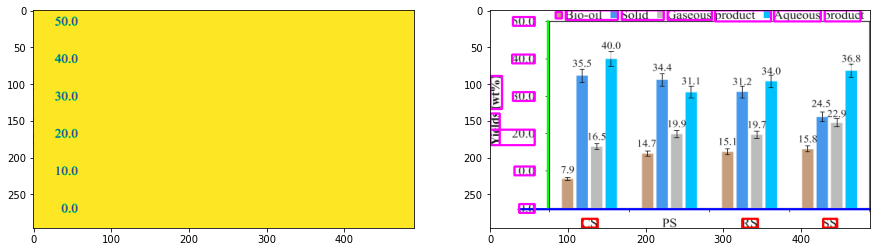

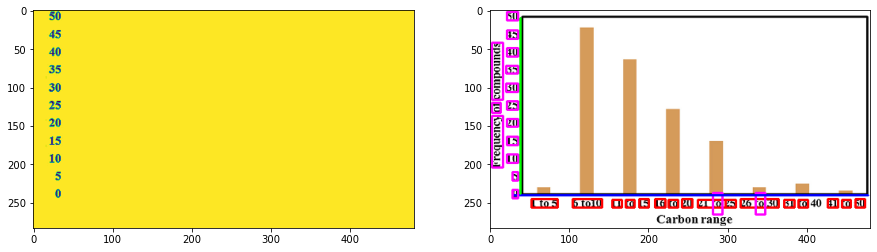

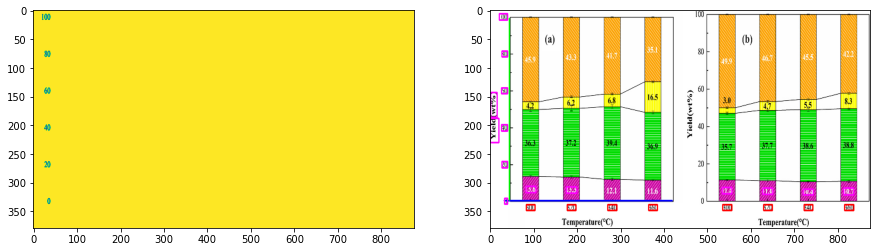

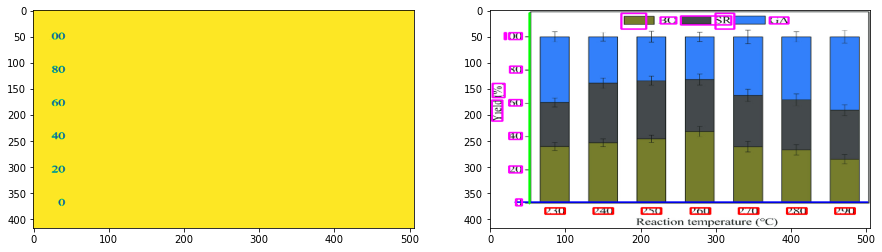

In [11]:
for path in Path(img_dir).iterdir():
    if path.name.endswith('.png') or path.name.endswith('.jpg') or path.name.endswith('.jpeg'):

        filepath = img_dir + "/" + path.name
        image = cv2.imread(filepath)
        height, width, channels = image.shape
        xaxis, yaxis = detectAxes(filepath)
        
        if xaxis is None or yaxis is None:
            continue
        
        for line in [xaxis]:
            for (x1, y1, x2, y2) in line:
                xaxis = (x1, y1, x2, y2)

        for line in [yaxis]:
            for (x1, y1, x2, y2) in line:
                yaxis = (x1, y1, x2, y2)
        
        gray, start_idx, end_idx = maskImageForwardPass(filepath, 1)
        y_text_list = getTextFromImageArray(gray, 'y-text')
        y_text = []
        for text, (textx, texty, w, h) in y_text_list:
            y_text.append(text)
        
        gray = maskImageBackwardPass(filepath, end_idx, yaxis[0])
        y_labels_list = getTextFromImageArray(gray, 'y-labels')
        y_labels = []
        for text, (textx, texty, w, h) in y_labels_list:
            y_labels.append(text)
            
        image_text = getTextFromImage(filepath, xaxis, yaxis)
        image, x_labels, _, legends = getProbableLabels(image, image_text, xaxis, yaxis)
        
        print("file name    :  ", path.name)
        print("x-labels     :  ", x_labels)
        print("y-text       :  ", y_text)
        print("y-labels     :  ", y_labels)
        print("legends      :  ", legends, end = "\n\n")
        
        rcParams['figure.figsize'] = 15, 4
        fig, ax = plt.subplots(1, 2)
        
        for (x1, y1, x2, y2) in [xaxis]:
            cv2.line(image, (x1, y1), (x2, y2),  (0, 0, 255), 2)
            
        for (x1, y1, x2, y2) in [yaxis]:
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        for text, (textx, texty, w, h) in y_text_list:
            cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 255), 2)
            
        for text, (textx, texty, w, h) in y_labels_list:
            cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 255), 2)
        
        ax[0].imshow(gray, aspect = 'auto')
        ax[1].imshow(image, aspect = 'auto')